In [69]:
import numpy as np
from scipy.integrate import solve_ivp
from numba import njit

In [70]:
# constants #

ki = 1.2e-06 # 1/s
kp = 500 # L/mol*s
ktc = 6e06 # L/mol*s
ktd = 6e06 # L/mol*s
kfm = 9.1e-02 # L/mol*s
kfp = 0.5 # L/mol*s
kpp = 0.05 # L/mol*s
f = 1.0
M0 = 8.4 # mol/L
I0 = 0.002 #mol/L

In [71]:
@njit
def lambda_0(I): # moment zero for radicals
    return np.sqrt((2 * f * ki * I) / ktd)

@njit
def lambda_1(M, L0, mu_1, mu_2): # momento one for radicals
    num = kp * M * L0 + kfp * L0 * mu_2
    denm = kfm * M + ktd * L0 + kfp * mu_1
    
    return num / denm

In [72]:
# Crear un array de 400 valores para n

n = np.arange(1, 401) * 2500  

# Crear un array con 400 elementos para b de propagación
b_p = 1.0 / np.diff(n)
b_p = np.append(b_p, b_p[-1])

In [73]:
def a_fraction(n):
    """
    Calcula la matriz de resultados con los índices, pares (p, l) y el valor de `ai`.

    Args:
        n (array-like): Array de valores a procesar.

    Returns:
        numpy.ndarray: Matriz con las columnas [idx, p, l, ai].
    """
    n = np.array(n)  # Asegurarse de que 'n' sea un array de numpy
    results = []  # Lista para almacenar los resultados

    for p in range(len(n)):
        for l in range(p, len(n)):
            nj, nk = n[p], n[l]
            njk = nj + nk
            idx = np.searchsorted(n, njk, side="right") - 1  # Encontrar índice del intervalo
            if idx >= 0 and idx < len(n) - 1:
                if njk == n[idx]:
                    ai = 0.0
                else:
                    ai = (n[idx + 1] - (n[p] + n[l])) / (n[idx + 1] - n[idx])
                results.append((idx, p, l, ai))  # Agregar resultado a la lista

    return np.array(results, dtype=object)  # Convertir la lista en un array NumPy

In [74]:
def b_fraction(a_results):
    # Filtrar las filas donde el primer elemento no sea 0
    filtered_results = a_results[a_results[:, 0] != 0]

    # Crear una copia para aplicar las transformaciones
    b = np.copy(filtered_results)

    # Incrementar el primer elemento en 1 y modificar el cuarto elemento
    b[:, 0] = b[:, 0] + 1  # Incrementar el primer elemento
    b[:, 3] = 1.0 - b[:, 3]  # Restar el cuarto elemento de 1.0

    return b

In [75]:
ai = a_fraction(n)
bi = b_fraction(ai)

In [76]:
filtered_results = ai[ai[:, 0] == 44]
filtered_results

array([[44, 0, 43, 0.0],
       [44, 1, 42, 0.0],
       [44, 2, 41, 0.0],
       [44, 3, 40, 0.0],
       [44, 4, 39, 0.0],
       [44, 5, 38, 0.0],
       [44, 6, 37, 0.0],
       [44, 7, 36, 0.0],
       [44, 8, 35, 0.0],
       [44, 9, 34, 0.0],
       [44, 10, 33, 0.0],
       [44, 11, 32, 0.0],
       [44, 12, 31, 0.0],
       [44, 13, 30, 0.0],
       [44, 14, 29, 0.0],
       [44, 15, 28, 0.0],
       [44, 16, 27, 0.0],
       [44, 17, 26, 0.0],
       [44, 18, 25, 0.0],
       [44, 19, 24, 0.0],
       [44, 20, 23, 0.0],
       [44, 21, 22, 0.0]], dtype=object)

In [81]:
# Función principal
def balances_KR(t, y):
    # Descomposición del vector de estados
    I = y[0]
    M = y[1]
    mu_0 = y[2]
    mu_1 = y[3]
    mu_2 = y[4]
    Nrd = y[5:405]  # Radicales
    Npd = y[405:805]  # Polímeros

    # Cálculo de momentos de los radicales
    L0 = lambda_0(I)
    L1 = lambda_1(M, L0, mu_1, mu_2)

    # Ecuaciones diferenciales
    dIdt = -ki * I
    dMdt = -(kp + kfm) * M * L0
    dmu_0dt = kfm * M * L0 + ktd * L0**2
    dmu_1dt = kp * M * L0
    dmu_2dt = kp * M * (L0 + 2 * L1)

    # Ecuaciones para los radicales y polímeros
    dNrdt = np.zeros_like(Nrd)
    dNpdt = np.zeros_like(Npd)

    for idx in range(len(Nrd)):
        if idx == 0:
            dNrdt[idx] = (- (kfm * M + (ktd + ktc) * L0 + kfp * mu_1) * Nrd[idx]
                          - kp * M * (b_p[idx] * Nrd[idx])
                          + kfp * L0 * n[idx] * Npd[idx]
                          + kfm * M * L0 + 2 * f * ki * I)
        else:
            dNrdt[idx] = (- (kfm * M + (ktd + ktc) * L0 + kfp * mu_1) * Nrd[idx]
                          + kp * M * (b_p[idx-1] * Nrd[idx-1] - b_p[idx] * Nrd[idx])
                          + kfp * L0 * n[idx] * Npd[idx])

    for idx in range(len(Npd)):
        # terminos para la terminación por combinación
        ai_idx = ai[ai[:, 0] == idx]
        bi_idx = bi[bi[:, 0] == idx]

        suma_1 = np.sum(ai_idx[:, 3] * Nrd[ai_idx[:, 1].astype(int)] * Nrd[ai_idx[:, 2].astype(int)])
        suma_2 = np.sum(bi_idx[:, 3] * Nrd[bi_idx[:, 1].astype(int)] * Nrd[bi_idx[:, 2].astype(int)])


        dNpdt[idx] = (- kfp * L0 * n[idx] * Npd[idx]
                      + (kfm * M + ktd * L0 + kfp * mu_1) * Nrd[idx]
                      + (ktc / 2) * (suma_1 + suma_2))

    # Concatenación de derivadas
    return np.concatenate(([dIdt, dMdt, dmu_0dt, dmu_1dt, dmu_2dt], dNrdt, dNpdt))

In [82]:
y0 = np.zeros(805)
y0[0] = I0
y0[1] = M0

time = [0, 5]
t_get = [100, 1000, 3500, 10000, 15000, 40000, 60000, 71100, 90000]

In [83]:
sol = solve_ivp(
      balances_KR,
      time, 
      y0, 
      #t_eval=t_get,
      method='LSODA',
      #rtol=1e-07,
      #atol=1e-10,
      vectorized=True
      )

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


KeyboardInterrupt: 

In [ ]:
sol.y[10]

array([0.00000000e+00, 0.00000000e+00, 2.37537410e-43, 8.96702308e-19,
       2.97072205e-11, 1.70306061e-10, 1.82362561e-10])

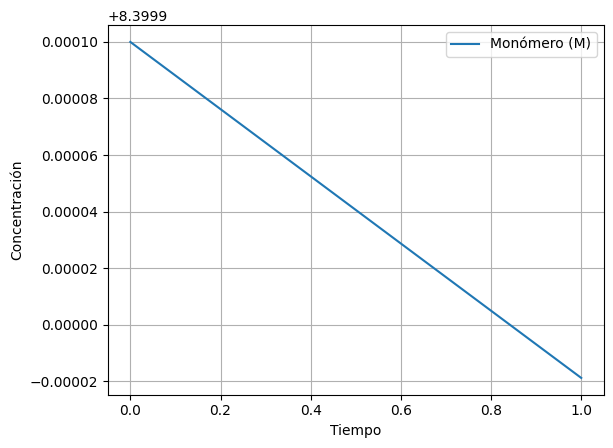

In [ ]:
# Visualización
import matplotlib.pyplot as plt

#plt.plot(sol.t, sol.y[0], label="Iniciador (I)")
plt.plot(sol.t, sol.y[1], label="Monómero (M)")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Concentración")
plt.grid()
plt.show()